<a href="https://colab.research.google.com/github/gillis42/csv_loc/blob/master/Orbital_Radiation_Visual_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tool to visualize trends is orbital radiation at different altitudes and inclinations**
 
The total radiation levels experienced by electronics in different orbits varies substantially based on the orbital altitude and inclination. It can be difficult to determine how a part, or board, designed for one application will fare in a different orbit. Results from several thousand orbital radiation simulations were used to plot heatmaps altitudes vs inclination with colour indicating radiation survivability. This should serve as a visual guide to show how application radiation levels, shielding levels and lifetimes will change at different orbits between Low Earth Orbit (LEO) and Geo-stationary Orbit (GEO).
 


---



# User guide 
 
This tool takes three parameters, two parameters must be fixed and one is left as a variable (set the value to 0):
*  **shield_thickness_mmAl**
  *   The equivalent aluminium thickness of the shielding used for your application (eg. you have a pre-designed 3 mm of shielding)
  *   **Variable:** For a given radiation tolerance and target lifetime the minimum amount of shielding will be calculated for each orbit
      *  For the purpose of making plots readable, shielding values over 99 mm are set to 99 mm)
      *  The colour scale is between 0 and 15 mm, everything over 15 mm is black and considered unrealistic
*  **min_TID_kRad**
  *   The minimum dose a board can survive (eg. the weakest part is 25 kRad)
  *   **Variable:** For a given shielding thickness and target lifetime the minimum survival TID will be calculated for each orbit
      *  For the purpose of making plots readable, doses over 999 kRad are set to 999 kRad
      *  The colour scale is between 0 and 100 kRad, everything over 100 kRad mm is black as few parts are capable of doses of 100 kRad
*  **time_on_orbit_years**
  *   The target mission duration (eg. 15 years on orbit)
  *   **Variable:** For a given shielding thickness and radiation tolerance the total survival time will be calculated for each orbit
      *  For the purpose of making plots readable, lifetimes over 99 years are set to 99
      *  The colour scale is between 0 and 15 years, everything over 15 mm is white as few missions require lifetimes over 15 years
 
# Disclaimer
 
This tool is designed to visually show trends and serve as an education tool for people less familiar with radiation on orbit. It should not replace detailed radiation analysis.


---


# Quick start

1.   Define two parameters, leave one as a variable (set to '0') 
2.   Hit the run-cell button (play icon on left hand side)




Will calculate maximum lifetime parts will survive for different orbits
Single page plot for reports (everything over 15 years is set to white as few missions require over 15 years):


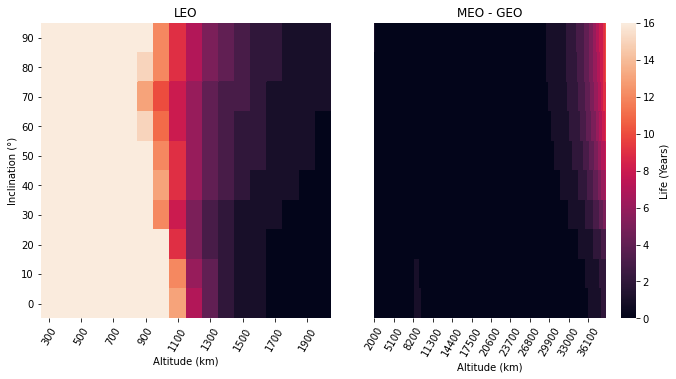

Whole page landscape detailed prints:
LEO (if life is greater than 99 years the value is set to 99 years to make plot readable):


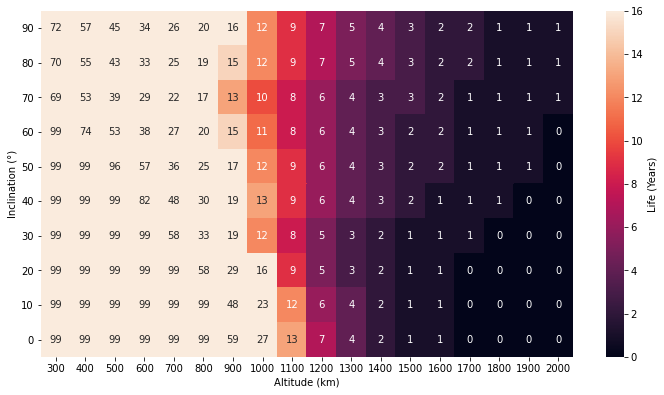

MEO - GEO:


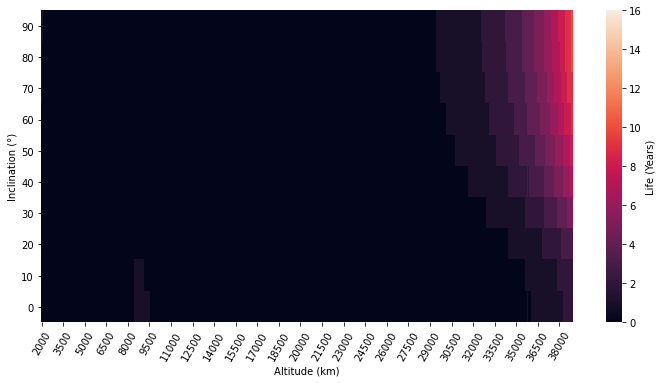

In [8]:
import sys
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files

#@title Define two parameters, leave one as a variable (set to '0')  { display-mode: "form" } { run: "auto" }
shield_thickness_mmAl = "5.0_mmAl" #@param ["0", "0.1_mmAl", "0.2_mmAl", "0.3_mmAl", "0.4_mmAl", "0.5_mmAl", "0.6_mmAl", "0.7_mmAl", "0.8_mmAl", "0.9_mmAl", "1.0_mmAl", "1.1_mmAl", "1.2_mmAl", "1.3_mmAl", "1.4_mmAl", "1.5_mmAl", "1.6_mmAl", "1.7_mmAl", "1.8_mmAl", "1.9_mmAl", "2.0_mmAl", "2.25_mmAl", "2.5_mmAl", "2.75_mmAl", "3.0_mmAl", "3.25_mmAl", "3.5_mmAl", "3.75_mmAl", "4.0_mmAl", "4.25_mmAl", "4.5_mmAl", "4.75_mmAl", "5.0_mmAl", "5.25_mmAl", "5.5_mmAl", "5.75_mmAl", "6.0_mmAl", "6.25_mmAl", "6.5_mmAl", "6.75_mmAl", "7.0_mmAl", "7.25_mmAl", "7.5_mmAl", "7.75_mmAl", "8.0_mmAl", "8.25_mmAl", "8.5_mmAl", "8.75_mmAl", "9.0_mmAl", "9.5_mmAl", "10.0_mmAl", "10.5_mmAl", "11.0_mmAl", "11.5_mmAl", "12.0_mmAl", "12.5_mmAl", "13.0_mmAl", "13.5_mmAl", "14.0_mmAl", "14.5_mmAl", "15.0_mmAl", "16.0_mmAl", "17.0_mmAl", "18.0_mmAl", "19.0_mmAl", "20.0_mmAl", "30.0_mmAl", "40.0_mmAl", "50.0_mmAl", "100.0_mmAl"]
min_TID_kRad =  50#@param {type:"number"}
time_on_orbit_years = 0 #@param {type:"number"}

# drive.mount('/content/gdrive')
# %cd "/content/gdrive/My Drive/Colab Notebooks/2_SWARM/20200511 - Post process multi-mission files/"
# %cd "2020-05-12_inc"
csv_url = '''https://raw.githubusercontent.com/gillis42/csv_loc/master/0_to_180deg_300_to_35000km_TIDrad%20(2).csv''' #https://www.dropbox.com/s/7b9fipfpptl553i/0_to_180deg_300_to_35000km_TIDrad.csv
# !ls -lrt

# df = pd.read_csv(csv_url, delimiter=',')
# df = pd.read_csv(csv_url, delimiter=',')
# df = df.drop('Unnamed: 0', 1)

#
# ---------------------------------------------------------------------
# ----------------- If statements based on what the user inputs are
# ---------------------------------------------------------------------
#

if shield_thickness_mmAl == "0" and min_TID_kRad != 0 and time_on_orbit_years != 0:
  print('Will calculate required shielding thickensses for different orbits:')

  # Read in files 
  df = pd.read_csv(csv_url, delimiter=',')
  df = df.drop('Unnamed: 0', 1)

  # Convert to krad per year (currently 5 year orbit)
  df.loc[:,"0.1_mmAl":"100.0_mmAl"] = df.loc[:,"0.1_mmAl":"100.0_mmAl"] / 5000

  # Calculate the annual TID expereiced
  tid_per_year = min_TID_kRad / time_on_orbit_years

  # Convert columnst to strings (to prevent the next section overwriting them)
  df_shield = df
  df_shield['Altitude_km'] = df_shield['Altitude_km'].astype(str)
  df_shield['Inclination_deg'] =   df_shield['Inclination_deg'].astype(str)

  # Boolean operator, highlight values that are greater than the annual TID
  filter_tid =  df_shield.loc[:,"0.1_mmAl":"100.0_mmAl"] > tid_per_year
  
  # Use boolean - Remove values that are greater than the annual TID
  df_shield[filter_tid] = np.nan

  # find the minimum shielding value required to meet annual TID
  min_value = df_shield.min(axis=1, skipna=True)

  # For each row / altitude, return the index of first col that isn't null 
  # THis returns the min shielding required in a series
  min_col = df_shield.loc[:,"0.1_mmAl":"100.0_mmAl"].idxmax(axis=1, skipna=True)

  # Append the min shielding values for each altitude to new column as float
  df_shield["mmAl"] = min_col.str[:-5].astype(float)

  # Get rid of other cols
  shield_required = df_shield.loc[:,["Altitude_km", "Inclination_deg", "mmAl"]]

  # Prep for plot, replace nan with 101 and anything over 99mm as 99mm
  shield_required = shield_required.replace(np.NaN,101)
  shield_required.loc[shield_required['mmAl']  >= 99, 'mmAl'] = 99


  shield_required['Altitude_km'] =   shield_required['Altitude_km'].astype(float).astype(int)
  shield_required['Inclination_deg'] =   shield_required['Inclination_deg'].astype(float).astype(int)

  #
  # ------------------------------------ Pretty plot not useful
  #

  # print('Pretty plot not useful:')
  # pivotted = pd.pivot_table(data=shield_required,
  #                     index='Inclination_deg',
  #                     values='mmAl',
  #                     columns='Altitude_km')

  # fig, ax = plt.subplots()

  # plt.rcParams['figure.figsize'] = (10.0, 5.0)
  # plt.rcParams['font.family'] = "serif"

  # ax = sns.heatmap(pivotted, vmin=0, vmax=10)#, annot=True)
  # plt.show()
  
  
  #
  # ----------------------------------PLOTS FOR REPORTS 
  #
  plt.rcParams['font.family'] = "Sans-serif"
  # Get rid of repeated values (90 - 180 is a mirror of 0 - 90)
  shield_required_plot_1 = shield_required[(shield_required['Inclination_deg'] < 91) & 
                                 (shield_required['Altitude_km'] < 2001)]
  shield_required_plot_2 = shield_required[(shield_required['Inclination_deg'] < 91) & 
                                 (shield_required['Altitude_km'] > 1999)]

  # Make pivot table for plts of 1) LEO, 2) MEO-GEO
  # Also sort so 0 it at bottom of graph not top
  pivotted_plot_1 = pd.pivot_table(data=shield_required_plot_1,
                      index='Inclination_deg',
                      values='mmAl',
                      columns='Altitude_km')
  pivotted_plot_1 = pivotted_plot_1.sort_values(by='Inclination_deg', 
                                                ascending=False)
  pivotted_plot_2 = pd.pivot_table(data=shield_required_plot_2,
                      index='Inclination_deg',
                      values='mmAl',
                      columns='Altitude_km')
  pivotted_plot_2 = pivotted_plot_2.sort_values(by='Inclination_deg', 
                                                ascending=False)

  # 
  # ---------- Start subplots for reports
  #

  print('Small, single page plot for reports  (everything over 15 mm is set to black and is considered unrealistic):')
  f, axes = plt.subplots(1, 2)#, figsize=(10, 10))

  sns.heatmap(pivotted_plot_1, cmap='rocket_r',# center=5,
                        vmin=0, vmax=16, ax=axes[0],
                        annot=False, fmt=".0f", cbar=None)
  sns.heatmap(pivotted_plot_2, cmap='rocket_r',# center=5,
                        vmin=0, vmax=16, ax=axes[1],
                        annot=False, fmt=".0f",
                        cbar_kws={'label': 'Shielding (mm Al)'})

  # Make Y labels horizontal
  for tick in axes[0].get_yticklabels():
      tick.set_rotation(0)
      
  # Make X labels readable
  for tick in axes[0].get_xticklabels():
      tick.set_rotation(60)
  for tick in axes[1].get_xticklabels():
      tick.set_rotation(60)
  
  # Axis labels 
  axes[0].set_xlabel('Altitude (km)')
  axes[1].set_xlabel('Altitude (km)')
  axes[0].set_ylabel('Inclination (\N{DEGREE SIGN})')
  axes[1].set_ylabel('')
  axes[1].yaxis.set_visible(False)
  axes[0].title.set_text('LEO')
  axes[1].title.set_text('MEO - GEO')

  # Tight fit, sizw and plot
  f.tight_layout(rect=[0, 0, .9, 1])
  f.set_size_inches(12, 6)

  # file_name = ('Life_%s_%s_kRad.png' % (shield_thickness_mmAl, 
  #                                       str(min_TID_kRad)))
  # plt.savefig(file_name, dpi=100)
  # files.download(file_name)
  plt.show()


  #
  # ------------------------------------------- PLOTS FOR REPORTS 
  #



  #
  # -------- LEO
  #          

  print('Whole page landscape detailed prints:')
  print('LEO (if required sielding is over 99 mmm, value is set to 99 mm to make plot readable):')
             
  fig, ax = plt.subplots()
  # plt.rcParams['font.family'] = "serif"

  ax = sns.heatmap(pivotted_plot_1, cmap='rocket_r',# center=5,
                        vmin=0, vmax=16,
                        annot=True, annot_kws={'size':10}, fmt=".1f",
                        cbar_kws={'label': 'Shielding (mm Al)'})
  
  for tick in ax.get_yticklabels():
      tick.set_rotation(0)

  for tick in ax.get_xticklabels():
      tick.set_rotation(0)
  
  fig.tight_layout(rect=[0, 0, .9, 1])
  fig.set_size_inches(12, 6)
  
  plt.xlabel('Altitude (km)')
  plt.ylabel('Inclination (\N{DEGREE SIGN})')

  # file_name = ('LEO_Life_%s_%s_kRad.png' % (shield_thickness_mmAl, 
  #                                           str(min_TID_kRad)))
  # plt.savefig(file_name, dpi=100)
  # files.download(file_name)
  plt.show()

  #
  # -------- MEO
  #          
  print('MEO - GEO:')
   
  fig, ax = plt.subplots()
  # plt.rcParams['font.family'] = "serif"

  ax = sns.heatmap(pivotted_plot_2, cmap='rocket_r',# center=5,
                        vmin=0, vmax=16,
                        annot=False, annot_kws={'size':10}, fmt=".1f",
                        cbar_kws={'label': 'Shielding (mm Al)'})
  
  for tick in ax.get_yticklabels():
      tick.set_rotation(0)
  for tick in ax.get_xticklabels():
      tick.set_rotation(60)
  
  fig.tight_layout(rect=[0, 0, .9, 1])
  fig.set_size_inches(12, 6)
  plt.xlabel('Altitude (km)')
  plt.ylabel('Inclination (\N{DEGREE SIGN})')
  # file_name = ('MEO_to_GEO_Life_%s_%s_kRad.png' % (shield_thickness_mmAl, 
  #                                                  str(min_TID_kRad)))
  # plt.savefig(file_name, dpi=100)
  # files.download(file_name)
  plt.show()



elif min_TID_kRad == 0 and shield_thickness_mmAl != "0" and time_on_orbit_years != 0:
  print('Will calculate maximum dose seen for different orbits')

  # Read in file
  df = pd.read_csv(csv_url, delimiter=',')
  df = df.drop('Unnamed: 0', 1)
  

  # Select alt, inc and approrpate shielded dose colums
  shielded_dose = df.loc[:,["Altitude_km", "Inclination_deg", 
                            shield_thickness_mmAl]]
  # convert to kRad for life
  shielded_dose[shield_thickness_mmAl] = shielded_dose[shield_thickness_mmAl] * (time_on_orbit_years / (5 * 1000))
  
  # Prep for plot -> Make all values ints
  shielded_dose['Altitude_km'] = shielded_dose['Altitude_km'].astype(float).astype(int)
  shielded_dose['Inclination_deg'] = shielded_dose['Inclination_deg'].astype(float).astype(int)
  shielded_dose[shield_thickness_mmAl] = shielded_dose[shield_thickness_mmAl].astype(float).astype(int)
  
  # To prevent heat map truncation, make everything over 999 = 999
  shielded_dose.loc[shielded_dose[shield_thickness_mmAl]  >= 999, 
                 shield_thickness_mmAl] = 999


  #
  # ------------------------------------------- Pretty plot
  #

  # print('Pretty plot but not all that useful')

  # fig, ax = plt.subplots()
  # pivotted_plot = pd.pivot_table(data=shielded_dose,
  #                     index='Inclination_deg',
  #                     values=shield_thickness_mmAl,
  #                     columns='Altitude_km')
  # ax = sns.heatmap(pivotted_plot, vmin=0, vmax=101)
  # plt.show()
  
 
  #
  # ------------------------------------------- PLOTS FOR REPORTS 
  # 

  print('Single page plot for reports (everything over 100 kRad is set to black):')
  plt.rcParams['font.family'] = "Sans-serif"


  # Get rid of repeated values (90 - 180 is a mirror of 0 - 90)
  shielded_dose_plot_1 = shielded_dose[(shielded_dose['Inclination_deg'] < 
                              91) & (shielded_dose['Altitude_km'] < 2001)]
  shielded_dose_plot_2 = shielded_dose[(shielded_dose['Inclination_deg'] < 
                              91) & (shielded_dose['Altitude_km'] > 1999)]




  # Make pivot table for plts of 1) LEO, 2) MEO-GEO
  # Also sort so 0 it at bottom of graph not top
  pivotted_plot_1 = pd.pivot_table(data=shielded_dose_plot_1,
                      index='Inclination_deg',
                      values=shield_thickness_mmAl,
                      columns='Altitude_km')
  pivotted_plot_1 = pivotted_plot_1.sort_values(by='Inclination_deg', 
                                                ascending=False)
  pivotted_plot_2 = pd.pivot_table(data=shielded_dose_plot_2,
                      index='Inclination_deg',
                      values=shield_thickness_mmAl,
                      columns='Altitude_km')
  pivotted_plot_2 = pivotted_plot_2.sort_values(by='Inclination_deg', 
                                                ascending=False)

  # 
  # ---------- Start subplots for reports
  #
  plt.rcParams['font.family'] = "Sans-serif"
  f, axes = plt.subplots(1, 2)#, figsize=(10, 10))

  sns.heatmap(pivotted_plot_1, cmap='rocket_r', # center=10, 
                        vmin=0, vmax=101, ax=axes[0],
                        annot=False, fmt=".0f", cbar=None)
  sns.heatmap(pivotted_plot_2, cmap='rocket_r', # center=10, 
                        vmin=0, vmax=101, ax=axes[1],
                        annot=False, fmt=".0f",
                        cbar_kws={'label': 'Minimum survival TID (kRad)'})

  # Make Y labels horizontal
  for tick in axes[0].get_yticklabels():
      tick.set_rotation(0)
      
  # Make X labels readable
  for tick in axes[0].get_xticklabels():
      tick.set_rotation(60)
  for tick in axes[1].get_xticklabels():
      tick.set_rotation(60)
  
  # Axis labels 
  axes[0].set_xlabel('Altitude (km)')
  axes[1].set_xlabel('Altitude (km)')
  axes[0].set_ylabel('Inclination (\N{DEGREE SIGN})')
  axes[1].set_ylabel('')
  axes[1].yaxis.set_visible(False)
  axes[0].title.set_text('LEO')
  axes[1].title.set_text('MEO - GEO')

  # Tight fit, sizw and plot
  f.tight_layout(rect=[0, 0, .9, 1])
  f.set_size_inches(12, 6)

  file_name = ('TID_%s_%s_years.png' % (shield_thickness_mmAl, 
                                        str(time_on_orbit_years)))
  plt.savefig(file_name, dpi=100)
  files.download(file_name)
  plt.show()


  #
  # -------- LEO
  #          

  print('Whole page landscape detailed prints:')
  print('LEO (all doses over 999 kRad set to 999 kRad to make plot readable):')
             
  fig, ax = plt.subplots()
  # plt.rcParams['font.family'] = "serif"

  ax = sns.heatmap(pivotted_plot_1, cmap='rocket_r', # center=10, 
                        vmin=0, vmax=101,
                        annot=True, annot_kws={'size':10}, fmt=".0f",
                        cbar_kws={'label': 'Minimum survival TID (kRad)'})
  
  for tick in ax.get_yticklabels():
      tick.set_rotation(0)  
  for tick in ax.get_xticklabels():
      tick.set_rotation(0)
  
  fig.tight_layout(rect=[0, 0, .9, 1])
  fig.set_size_inches(12, 6)
  
  plt.xlabel('Altitude (km)')
  plt.ylabel('Inclination (\N{DEGREE SIGN})')

  file_name = ('LEO_TID_%s_%s_years.png' % (shield_thickness_mmAl, 
                                        str(time_on_orbit_years)))
  plt.savefig(file_name, dpi=100)
  files.download(file_name)
  plt.show()

  #
  # -------- MEO
  #          
  print('MEO - GEO:')
  fig, ax = plt.subplots()

  ax = sns.heatmap(pivotted_plot_2, cmap='rocket_r', # center=10, 
                        vmin=0, vmax=101,
                        annot=False, annot_kws={'size':10}, fmt=".0f",
                        cbar_kws={'label': 'Minimum survival TID (kRad)'})
  
  for tick in ax.get_yticklabels():
      tick.set_rotation(0)
  for tick in ax.get_xticklabels():
      tick.set_rotation(60)
  
  fig.tight_layout(rect=[0, 0, .9, 1])
  fig.set_size_inches(12, 6)
  plt.xlabel('Altitude (km)')
  plt.ylabel('Inclination (\N{DEGREE SIGN})')
  file_name = ('MEO_to_GEO_TID_%s_%s_years.png' % (shield_thickness_mmAl, 
                                        str(time_on_orbit_years)))
  plt.savefig(file_name, dpi=100)
  files.download(file_name)
  plt.show()


elif time_on_orbit_years == 0 and shield_thickness_mmAl != "0" and min_TID_kRad != 0 :
  print('Will calculate maximum lifetime parts will survive for different orbits')

  # Read in file
  df = pd.read_csv(csv_url, delimiter=',')
  df = df.drop('Unnamed: 0', 1)
  
  # Select alt, inc and approrpate shielded dose colums
  life_years = df.loc[:,["Altitude_km", "Inclination_deg", 
                         shield_thickness_mmAl]]

  # Work out lifetime at each orbit
  life_years[shield_thickness_mmAl] = min_TID_kRad / (life_years[shield_thickness_mmAl] / (5 * 1000) )
  
  # Replace infinities with useable (but large) value
  life_years = life_years.replace([np.inf, -np.inf, np.nan], 10000)
  
  # Prep for plot -> Make all values ints
  life_years['Altitude_km'] = life_years['Altitude_km'].astype(float).astype(int)
  life_years['Inclination_deg'] = life_years['Inclination_deg'].astype(float).astype(int)
  life_years[shield_thickness_mmAl] = life_years[shield_thickness_mmAl].astype(float).astype(int)
  
  # To prevent heat map truncation, make everything over 99 = 99
  life_years.loc[life_years[shield_thickness_mmAl]  >= 99, 
                 shield_thickness_mmAl] = 99

  #
  # ------------------------------------------- Pretty plot
  #

  # print('Pretty plot but not all that useful')

  # fig, ax = plt.subplots()
  # pivotted_plot = pd.pivot_table(data=life_years,
  #                     index='Inclination_deg',
  #                     values=shield_thickness_mmAl,
  #                     columns='Altitude_km')
  # ax = sns.heatmap(pivotted_plot, vmin=10, vmax=20)
  # plt.show()

  #
  # ------------------------------------------- PLOTS FOR REPORTS 
  # 

  print('Single page plot for reports (everything over 15 years is set to white as few missions require over 15 years):')
  plt.rcParams['font.family'] = "Sans-serif"


  # Get rid of repeated values (90 - 180 is a mirror of 0 - 90)
  life_years_plot_1 = life_years[(life_years['Inclination_deg'] < 91) & 
                                 (life_years['Altitude_km'] < 2001)]
  life_years_plot_2 = life_years[(life_years['Inclination_deg'] < 91) & 
                                 (life_years['Altitude_km'] > 1999)]

  # Make pivot table for plts of 1) LEO, 2) MEO-GEO
  # Also sort so 0 it at bottom of graph not top
  pivotted_plot_1 = pd.pivot_table(data=life_years_plot_1,
                      index='Inclination_deg',
                      values=shield_thickness_mmAl,
                      columns='Altitude_km')
  pivotted_plot_1 = pivotted_plot_1.sort_values(by='Inclination_deg', 
                                                ascending=False)
  pivotted_plot_2 = pd.pivot_table(data=life_years_plot_2,
                      index='Inclination_deg',
                      values=shield_thickness_mmAl,
                      columns='Altitude_km')
  pivotted_plot_2 = pivotted_plot_2.sort_values(by='Inclination_deg', 
                                                ascending=False)

  # 
  # ---------- Start subplots for reports
  #
  plt.rcParams['font.family'] = "Sans-serif"
  f, axes = plt.subplots(1, 2)#, figsize=(10, 10))

  sns.heatmap(pivotted_plot_1, cmap='rocket', # center=10, 
                        vmin=0, vmax=16, ax=axes[0],
                        annot=False, fmt=".0f", cbar=None)
  sns.heatmap(pivotted_plot_2, cmap='rocket', # center=10, 
                        vmin=0, vmax=16, ax=axes[1],
                        annot=False, fmt=".0f",
                        cbar_kws={'label': 'Life (Years)'})

  # Make Y labels horizontal
  for tick in axes[0].get_yticklabels():
      tick.set_rotation(0)
      
  # Make X labels readable
  for tick in axes[0].get_xticklabels():
      tick.set_rotation(60)
  for tick in axes[1].get_xticklabels():
      tick.set_rotation(60)
  
  # Axis labels 
  axes[0].set_xlabel('Altitude (km)')
  axes[1].set_xlabel('Altitude (km)')
  axes[0].set_ylabel('Inclination (\N{DEGREE SIGN})')
  axes[1].set_ylabel('')
  axes[1].yaxis.set_visible(False)
  axes[0].title.set_text('LEO')
  axes[1].title.set_text('MEO - GEO')

  # Tight fit, sizw and plot
  f.tight_layout(rect=[0, 0, .9, 1])
  f.set_size_inches(12, 6)

  file_name = ('Life_%s_%s_kRad.png' % (shield_thickness_mmAl, 
                                        str(min_TID_kRad)))
  plt.savefig(file_name, dpi=100)
  files.download(file_name)
  plt.show()

  #
  # -------- LEO
  #          

  print('Whole page landscape detailed prints:')
  print('LEO (if life is greater than 99 years the value is set to 99 years to make plot readable):')
             
  fig, ax = plt.subplots()
  # plt.rcParams['font.family'] = "serif"

  ax = sns.heatmap(pivotted_plot_1, cmap='rocket', # center=10, 
                        vmin=0, vmax=16,
                        annot=True, annot_kws={'size':10}, fmt=".0f",
                        cbar_kws={'label': 'Life (Years)'})
  
  for tick in ax.get_yticklabels():
      tick.set_rotation(0)  
  for tick in ax.get_xticklabels():
      tick.set_rotation(0)
  
  fig.tight_layout(rect=[0, 0, .9, 1])
  fig.set_size_inches(12, 6)
  
  plt.xlabel('Altitude (km)')
  plt.ylabel('Inclination (\N{DEGREE SIGN})')

  file_name = ('LEO_Life_%s_%s_kRad.png' % (shield_thickness_mmAl, 
                                            str(min_TID_kRad)))
  plt.savefig(file_name, dpi=100)
  files.download(file_name)
  plt.show()

  #
  # -------- MEO
  #          
  print('MEO - GEO:')
  fig, ax = plt.subplots()

  ax = sns.heatmap(pivotted_plot_2, cmap='rocket', # center=10, 
                        vmin=0, vmax=16,
                        annot=False, annot_kws={'size':10}, fmt=".0f",
                        cbar_kws={'label': 'Life (Years)'})
  
  for tick in ax.get_yticklabels():
      tick.set_rotation(0)
  for tick in ax.get_xticklabels():
      tick.set_rotation(60)
  
  fig.tight_layout(rect=[0, 0, .9, 1])
  fig.set_size_inches(12, 6)
  plt.xlabel('Altitude (km)')
  plt.ylabel('Inclination (\N{DEGREE SIGN})')
  file_name = ('MEO_to_GEO_Life_%s_%s_kRad.png' % (shield_thickness_mmAl, 
                                                   str(min_TID_kRad)))
  plt.savefig(file_name, dpi=100)
  files.download(file_name)
  plt.show()


  

else:
  print('Either more than one parameter is zero or no parameters are zero, this will cause a failure!')

# **Application notes on method and limitations**

# Orbital radaition simulations and data

The data presented here are based on OMERE orbital radiation simulations. Orbits were simulated between 300 km and 38,000 km in 100 km steps, and at inclinations between equitorial and sun-synchronous orbit (0 and 90 degrees) in 10 degree steps. All orbits are circular. 

The radiation simulation models used, the following models and inputs:

*   Orbit generation:
  *   Number of orbits per simulation: 400
  *   Number of sample points per orbit: 100
  *   Duration: 5 years 
*   Radiation models to calculated TID:
  *   Trapped proton and electron fluxes: AP-8 (Solar Min), AE-8 (Solar Max)
  *   Solar particle average flux: ESP, 90% Confidence
      *   90% of the time this model will overestimate the total dose from solar particles
  *   Shielding calculations: ShieldDose-2, Silicon at the center of aluminium sphere

Results from all simulations are stored as a single csv file for fast sampling and plotting. Results are stored as a single row for each altitude and inclination with columns for the Total Ionizing Dose (TID) at shileiding thicknesses between 0.1 and 100 mm of aluminium.


# Limitations

This tool does not consider non-cicrular orbits or transfer orbits such as GEO transfer. 

Some insight can be gained on GEO transfer orbits based on the severe radiation conditions between LEO and GEO. This indicates that transfer time is critical to ensuring survival of electronics moving from LEO to GEO orbits. 



